In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, train_test_split
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import random
from math import pi
import statsmodels.api as sm
plt.style.use('fivethirtyeight')
from statsmodels.tsa.seasonal import seasonal_decompose
class CFG:
    data_folder = '/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/Data/'
    img_dim1 = 20
    img_dim2 = 10
    img_dim1 = 20
    img_dim2 = 10

random.seed(777)


In [3]:
def reading_data(path:str):
    train = pd.read_csv(path + "train.csv")
    test = pd.read_csv(path + "test.csv")
    test_id = test['id']  # store the 'id' column from the test dataframe
    for df in (train, test):
        df['date'] = pd.to_datetime(df['date'])
        df.set_index(df['date'], inplace=True)
    return train, test, test_id
train, test, test_ids = reading_data(CFG.data_folder)

# Feature Engineering - Time Series

In [4]:
train.head()

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
date,,,,,,,,,,,,,,,,,,
2020-12-05,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
2020-12-06,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2020-12-07,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07
2020-12-08,Prague_1,2020-12-08,6550.0,NaN,0,0,0,0,0,0,0,0.0,0,0.8,0.0,1681.0,32423.0,Prague_1_2020-12-08
2020-12-09,Prague_1,2020-12-09,6910.0,NaN,0,0,0,0,0,0,0,0.0,0,0.5,0.0,1704.0,32410.0,Prague_1_2020-12-09


In [5]:
train.describe()

,date,orders,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2
count,7340,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7070.000000,7070.000000,7340.000000,7340.000000
mean,2022-08-27 18:17:27.629427968,5535.443869,0.027248,0.000136,0.000545,0.010899,0.029973,0.007084,0.000954,0.221499,0.000272,1.621126,0.290112,1633.545777,23477.031335
min,2020-12-05 00:00:00,790.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,482.000000,1797.000000
25%,2021-11-23 00:00:00,4434.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,945.000000,18509.000000
50%,2022-09-08 00:00:00,5370.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1349.000000,22267.000000
75%,2023-06-13 06:00:00,7009.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2308.000000,30028.750000
max,2024-03-15 00:00:00,18139.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,80.000000,19.840000,3437.000000,45769.000000
std,NaN,2182.680279,0.162816,0.011672,0.023340,0.103836,0.170524,0.083876,0.030869,0.410293,0.016506,4.542875,1.546102,784.167637,8934.848328


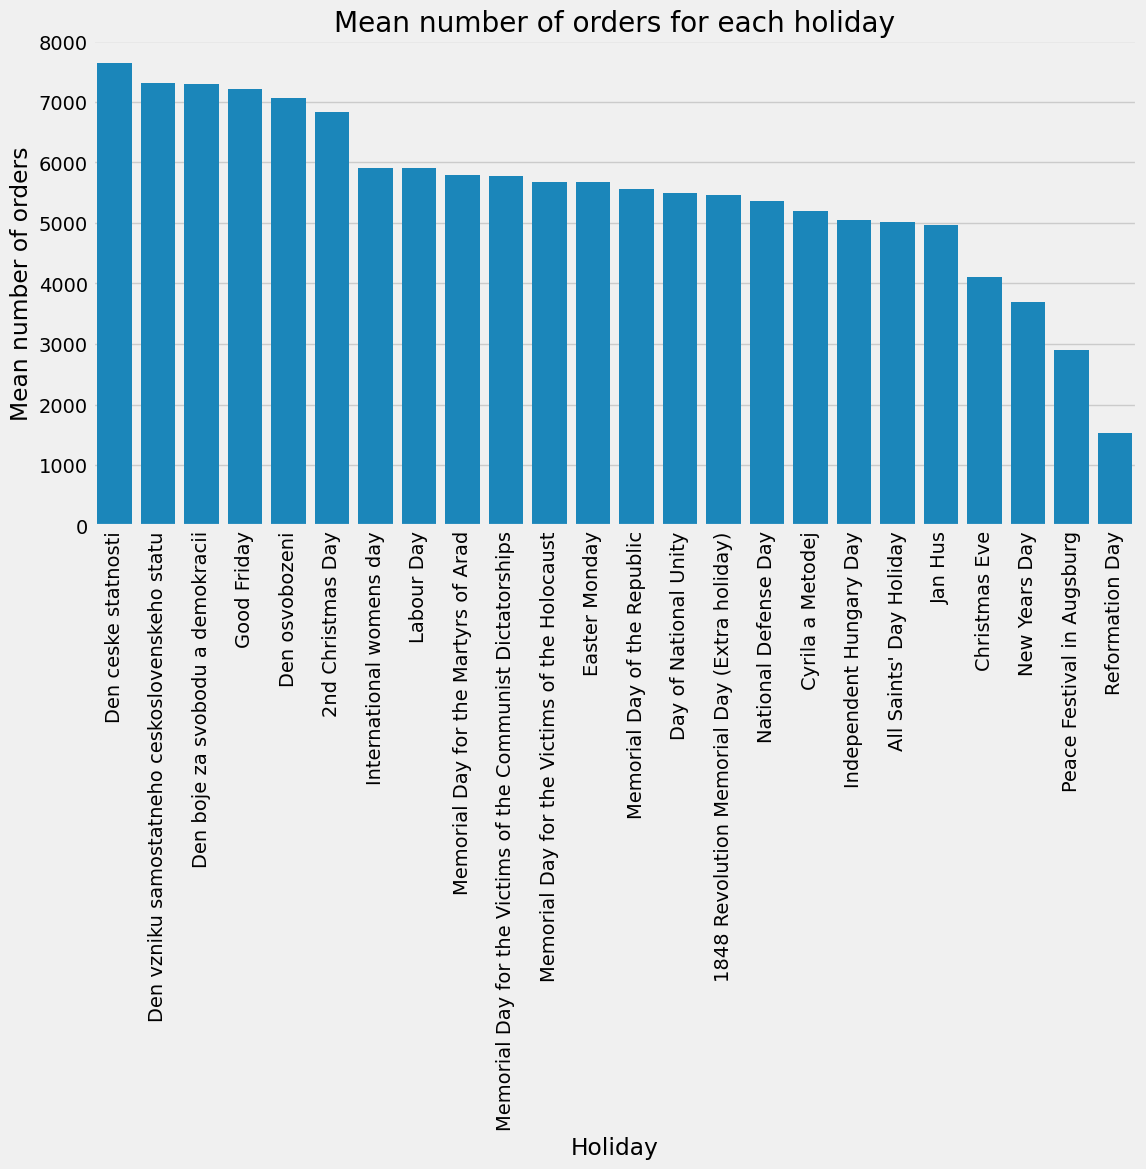

In [6]:
holiday_orders = train.groupby('holiday_name')['orders'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=holiday_orders.index, y=holiday_orders.values)
plt.title('Mean number of orders for each holiday')
plt.xlabel('Holiday')
plt.ylabel('Mean number of orders')
plt.xticks(rotation=90)
plt.show()

In [7]:
def get_time_features(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:
    for df in (train, test):
        df['Date'] = pd.to_datetime(df['date'])
        df['date_day'] = df['Date'].dt.day
        df['date_day_of_year'] = df['Date'].dt.dayofyear
        df['date_month'] = df['Date'].dt.month
        df['Year'] = df['Date'].dt.year
        df['month_sin'] = df['date_month'] * np.sin(2 * pi * df['date_month'])
        df['month_cos'] = df['date_month'] * np.cos(2 * pi * df['date_month'])
        df['friday'] = (df['Date'].dt.dayofweek == 4).astype(int)
        df['day_sin'] = df['date_day'] * np.sin(2 * pi * df['date_day'])
        df['day_cos'] = df['date_day'] * np.cos(2 * pi * df['date_day'])
        df['year_sin'] = np.sin(2 * pi * df["date_day_of_year"])
        df['year_cos'] = np.cos(2 * pi * df['date_day_of_year'])
        df['holiday_before'] = df['holiday'].shift(1).fillna(0).astype(int)
        df['holiday_after'] = df['holiday'].shift(-1).fillna(0).astype(int)

        #df['Weekday'] = df['Date'].dt.weekday
        #df['Month_Day'] = df['Month'].astype(str) + '-' + df['Day'].astype(str)
        #df['Year_Week'] = df['Year'].astype(str) + '-' + df['Weekday'].astype(str)
        #df['Month_lag1'] = df['Month'].shift(1)
        #df['Month_lag2'] = df['Month'].shift(2)
        df.drop(columns=['Date'], inplace=True)
    return train, test

train, test = get_time_features(train=train, test=test)


In [8]:
test.describe()

,date,holiday,shops_closed,winter_school_holidays,school_holidays,date_day,date_day_of_year,date_month,Year,month_sin,month_cos,friday,day_sin,day_cos,year_sin,year_cos,holiday_before,holiday_after
count,397,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.0,3.970000e+02,397.000000,397.000000,3.970000e+02,397.000000,3.970000e+02,397.0,397.000000,397.000000
mean,2024-04-15 01:48:48.967254528,0.068010,0.020151,0.020151,0.070529,15.785894,106.075567,3.984887,2024.0,-4.011412e-15,3.984887,0.133501,-9.494797e-14,15.785894,-2.684012e-14,1.0,0.068010,0.068010
min,2024-03-16 00:00:00,0.000000,0.000000,0.000000,0.000000,1.000000,76.000000,3.000000,2024.0,-6.123234e-15,3.000000,0.000000,-6.467621e-13,1.000000,-8.623494e-14,1.0,0.000000,0.000000
25%,2024-03-31 00:00:00,0.000000,0.000000,0.000000,0.000000,8.000000,91.000000,3.000000,2024.0,-3.918870e-15,3.000000,0.000000,-1.616905e-13,8.000000,-5.291217e-14,1.0,0.000000,0.000000
50%,2024-04-15 00:00:00,0.000000,0.000000,0.000000,0.000000,16.000000,106.000000,4.000000,2024.0,-3.918870e-15,4.000000,0.000000,-2.449294e-14,16.000000,-2.743209e-14,1.0,0.000000,0.000000
75%,2024-04-30 00:00:00,0.000000,0.000000,0.000000,0.000000,23.000000,121.000000,4.000000,2024.0,-2.204364e-15,4.000000,0.000000,-2.204364e-15,23.000000,9.903690e-18,1.0,0.000000,0.000000
max,2024-05-15 00:00:00,1.000000,1.000000,1.000000,1.000000,31.000000,136.000000,5.000000,2024.0,-2.204364e-15,5.000000,1.000000,2.039100e-13,31.000000,3.137077e-14,1.0,1.000000,1.000000
std,NaN,0.252081,0.140694,0.140694,0.256359,8.643442,17.614684,0.706945,0.0,1.388005e-15,0.706945,0.340545,1.723251e-13,8.643442,3.264503e-14,0.0,0.252081,0.252081


# EDA

In [9]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,min,25%,50%,75%,max,std
date,datetime64[ns],7340,1193,16.253406,0,0.000000,2022-08-27 18:17:27.629427968,2020-12-05 00:00:00,2021-11-23 00:00:00,2022-09-08 00:00:00,2023-06-13 06:00:00,2024-03-15 00:00:00,nan
date_day,int32,7340,31,0.422343,0,0.000000,15.677112,1.000000,8.000000,16.000000,23.000000,31.000000,8.764848
date_day_of_year,int32,7340,366,4.986376,0,0.000000,178.565123,1.000000,76.000000,178.000000,275.000000,366.000000,109.640686
date_month,int32,7340,12,0.163488,0,0.000000,6.379019,1.000000,3.000000,6.000000,10.000000,12.000000,3.587490
Year,int32,7340,5,0.068120,0,0.000000,2022.167711,2020.000000,2021.000000,2022.000000,2023.000000,2024.000000,0.951798
holiday,int64,7340,2,0.027248,0,0.000000,0.027248,0.000000,0.000000,0.000000,0.000000,1.000000,0.162816
shutdown,int64,7340,2,0.027248,0,0.000000,0.000136,0.000000,0.000000,0.000000,0.000000,1.000000,0.011672
mini_shutdown,int64,7340,2,0.027248,0,0.000000,0.000545,0.000000,0.000000,0.000000,0.000000,1.000000,0.023340
shops_closed,int64,7340,2,0.027248,0,0.000000,0.010899,0.000000,0.000000,0.000000,0.000000,1.000000,0.103836
winter_school_holidays,int64,7340,2,0.027248,0,0.000000,0.029973,0.000000,0.000000,0.000000,0.000000,1.000000,0.170524


In [10]:
print(train['date'].tail()),
print(test['date'].tail())

date
2024-03-10   2024-03-10
2024-03-11   2024-03-11
2024-03-12   2024-03-12
2024-03-13   2024-03-13
2024-03-14   2024-03-14
Name: date, dtype: datetime64[ns]
date
2024-05-11   2024-05-11
2024-05-12   2024-05-12
2024-05-13   2024-05-13
2024-05-14   2024-05-14
2024-05-15   2024-05-15
Name: date, dtype: datetime64[ns]


In [11]:
pd.set_option('display.max_rows', 10)

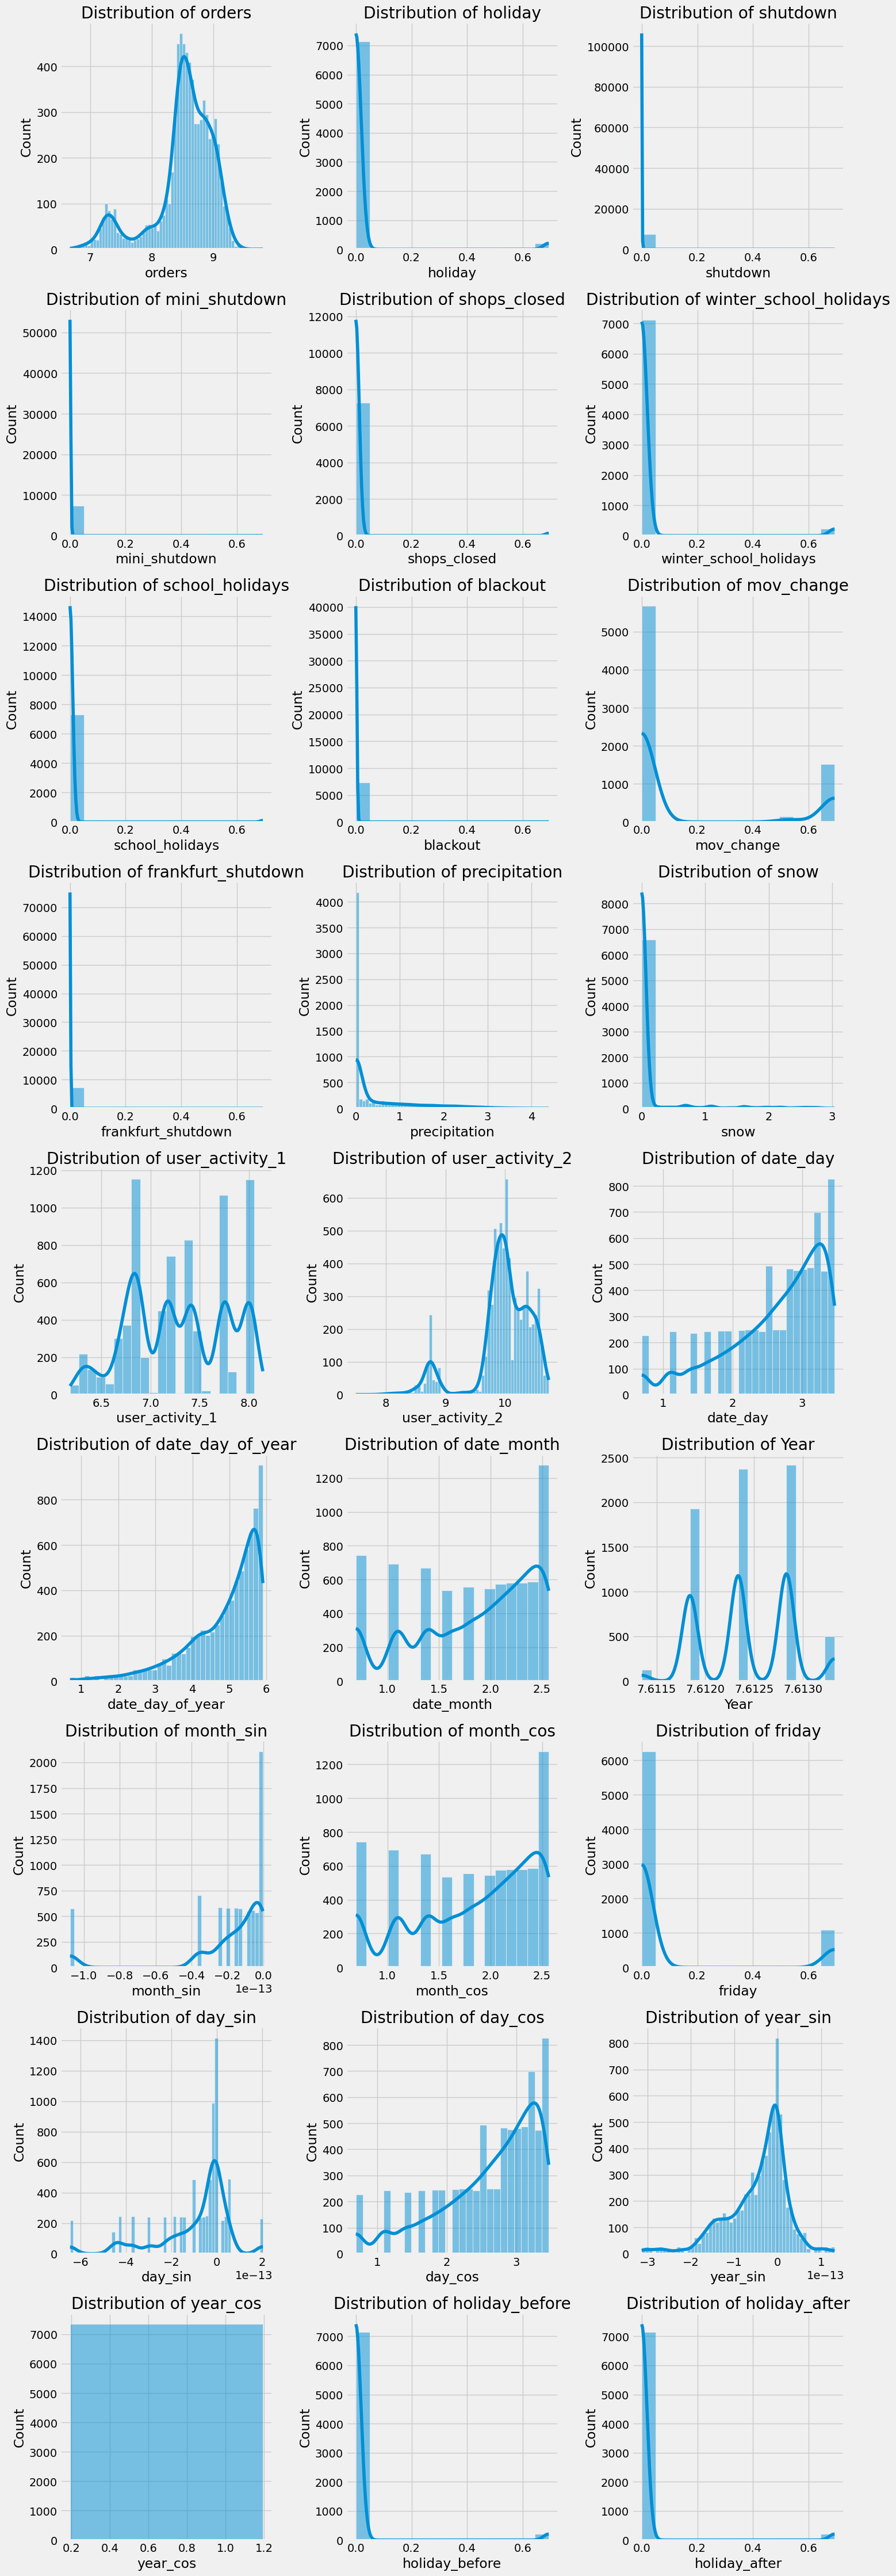

In [12]:
def plot_numerical_distributions(dataset):
    numerical_cols = dataset.select_dtypes(include=['number']).columns
    n_cols = 3
    n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    for i, col in enumerate(numerical_cols):
        dataset[col] = dataset[col].apply(np.log1p)
        sns.histplot(dataset[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()
plot_numerical_distributions(dataset=train)

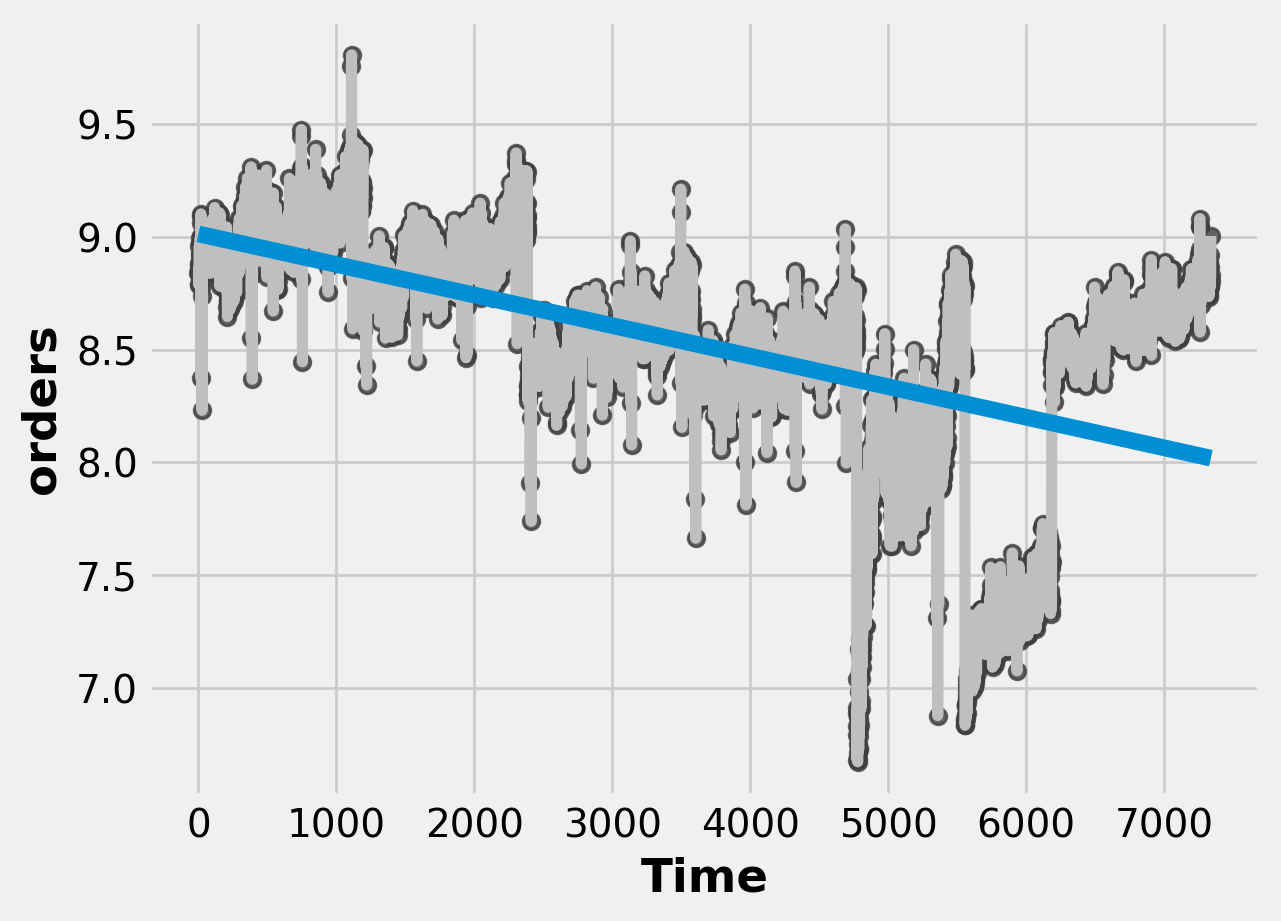

In [13]:
train['Time'] = np.arange(len(train.index))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots()
ax.plot('Time', 'orders', data=train, color='0.75')
ax = sns.regplot(x='Time', y='orders', data=train, ci=None, scatter_kws=dict(color='0.25'))

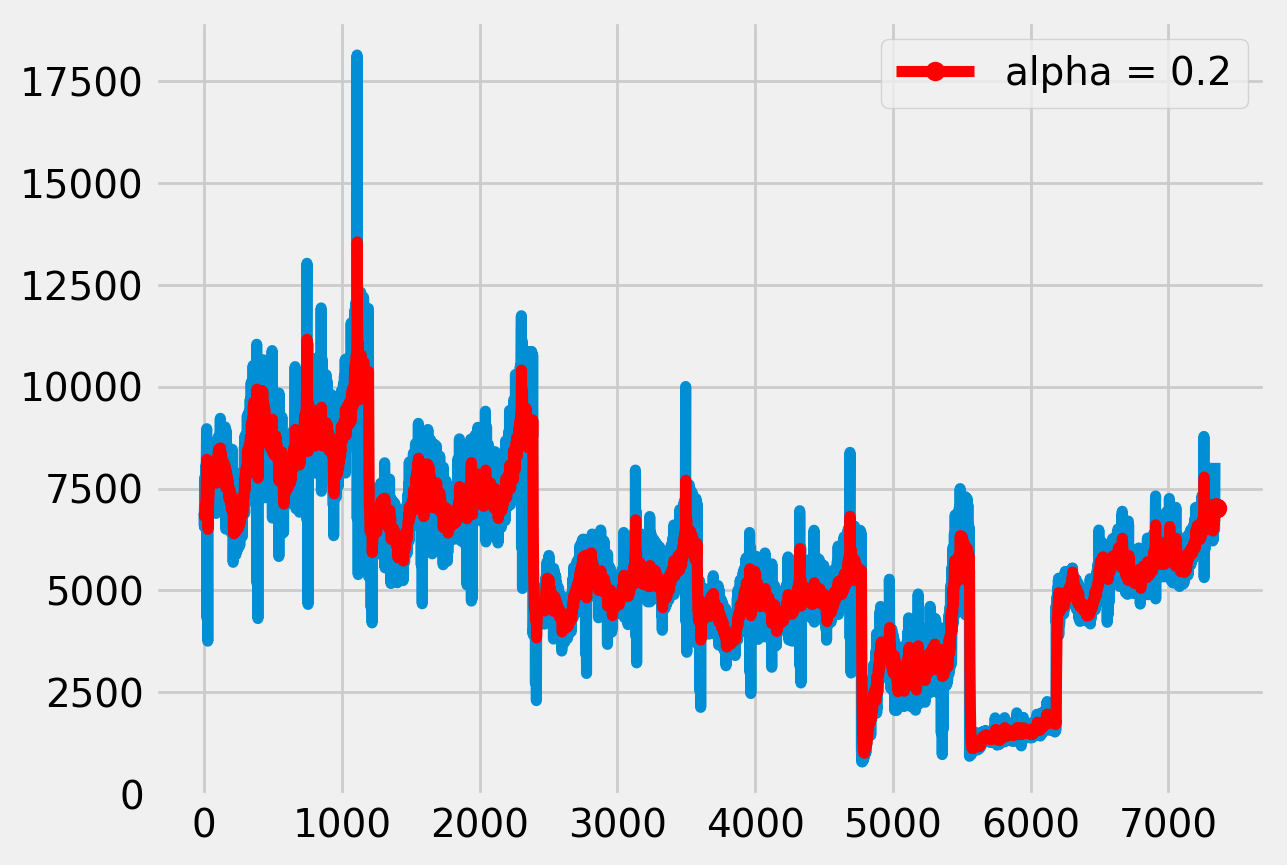

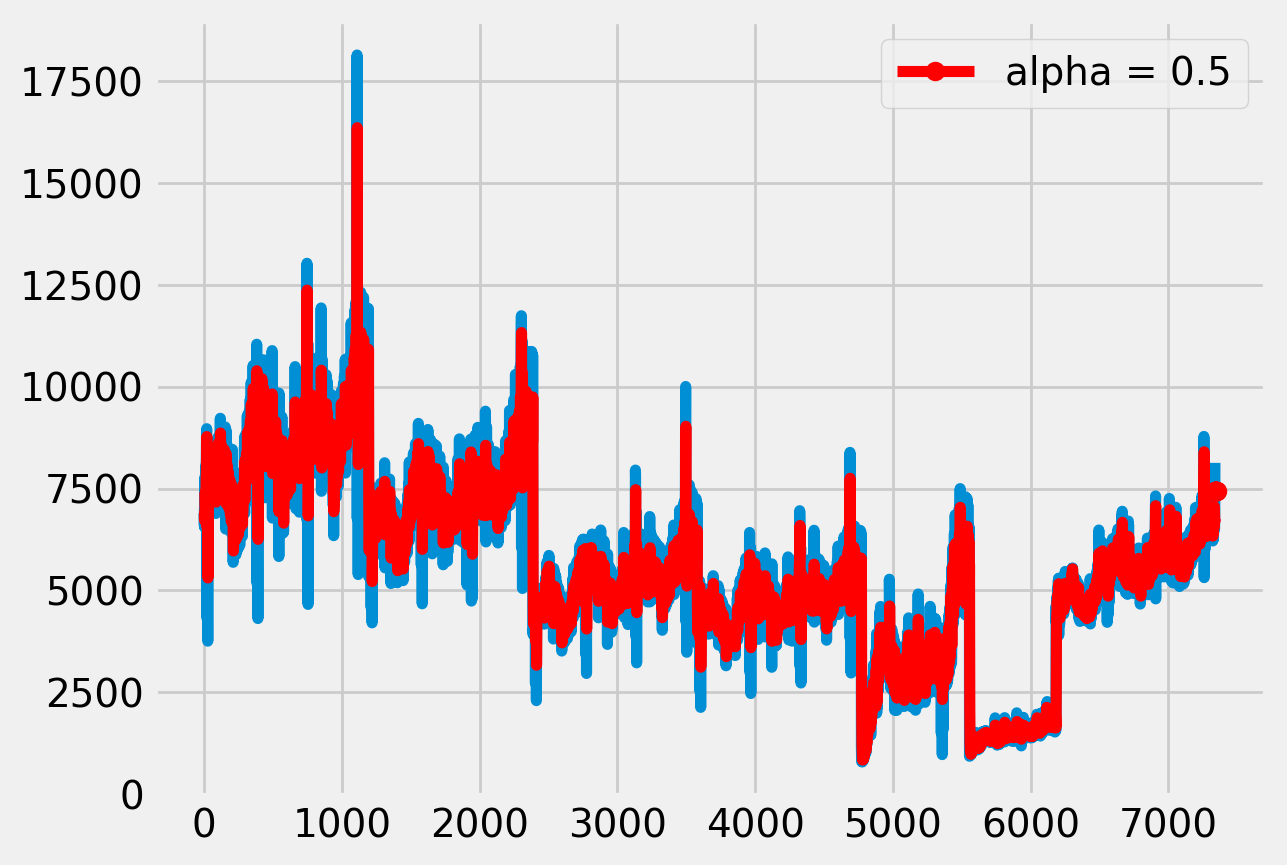

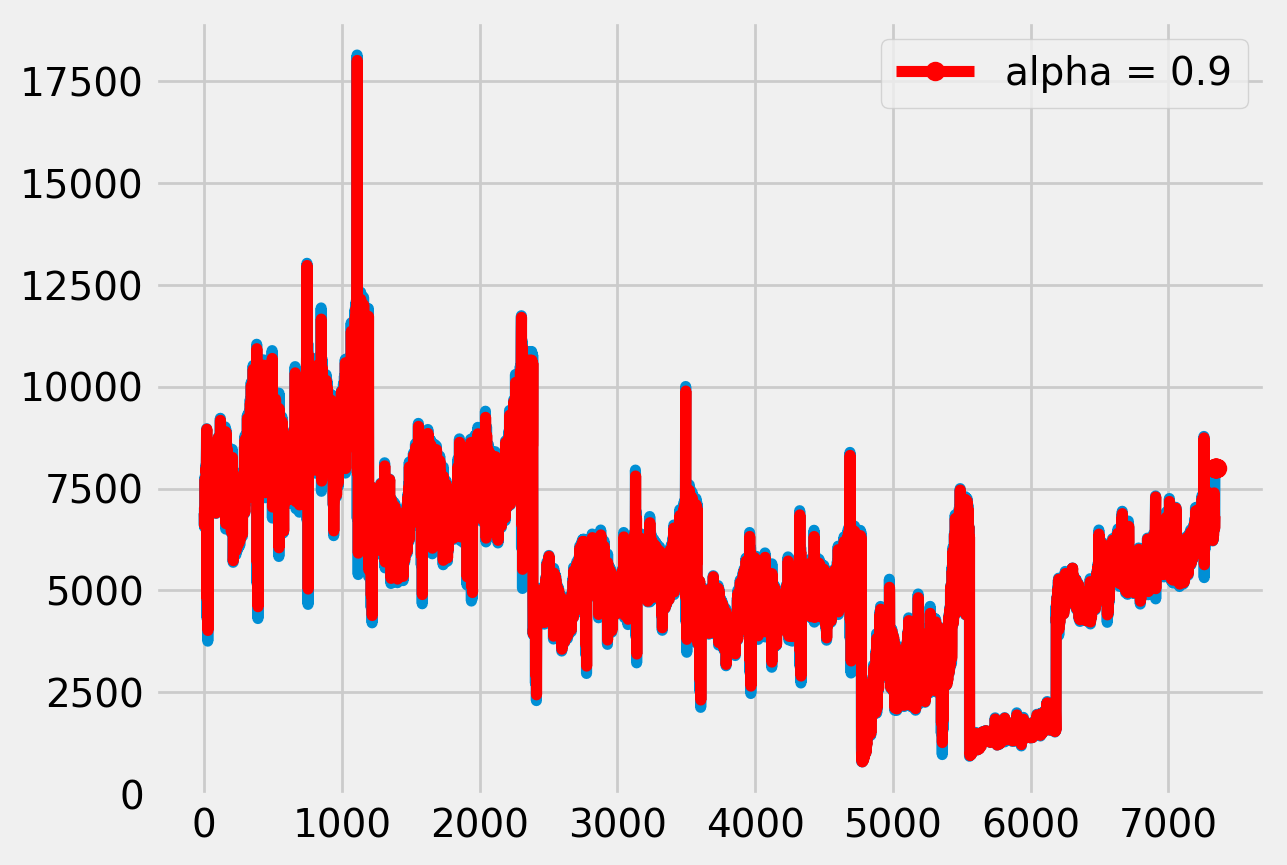

In [14]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
for alpha_sm in [0.2 , 0.5, 0.9]:
    df = pd.read_csv(CFG.data_folder + 'train.csv');
    df['orders'].plot.line()
    fit1 = SimpleExpSmoothing(df['orders']).fit(smoothing_level = alpha_sm  ,optimized=False)
    fcast1 = fit1.forecast(12).rename('alpha = ' + str(alpha_sm))
    fcast1.plot(marker='o', color='red', legend=True)
    fit1.fittedvalues.plot(  color='red')
    plt.show()

NameError: name 'alpha' is not defined

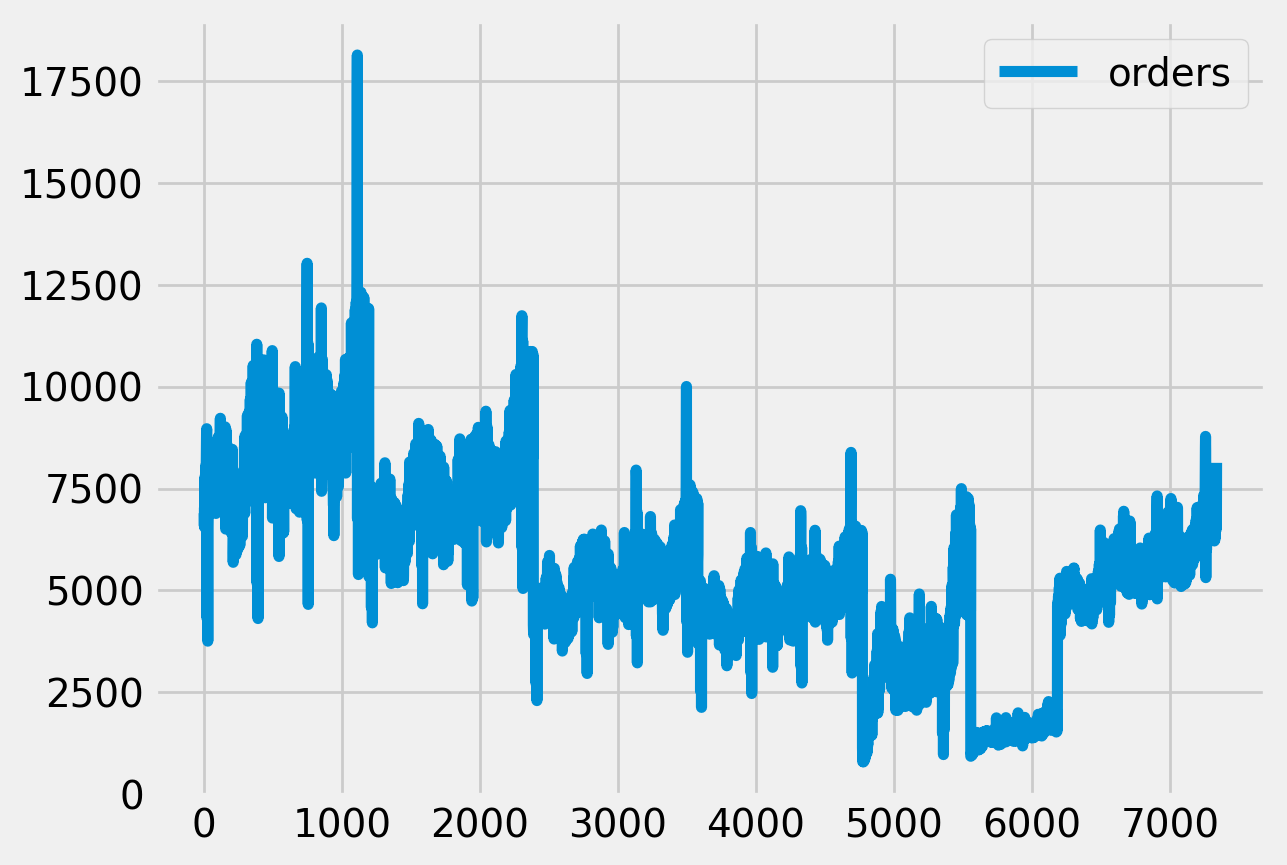

In [15]:
df = pd.read_csv(CFG.data_folder + 'train.csv', usecols = ['orders'])
df.plot.line()
fit1 = SimpleExpSmoothing(df).fit(smoothing_level= alpha,optimized=False)
fcast1 = fit1.forecast(12).rename(r'$\alpha=0.5$')
fcast1.plot(marker='o', color='red', legend=True)
fit1.fittedvalues.plot(  color='red')
plt.show()

df.plot.line()

fit1 = Holt(df).fit(smoothing_level=0.5, smoothing_slope=0.5, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit1.fittedvalues.plot(color='red')
fcast1.plot(color='red', legend=True)

plt.show()

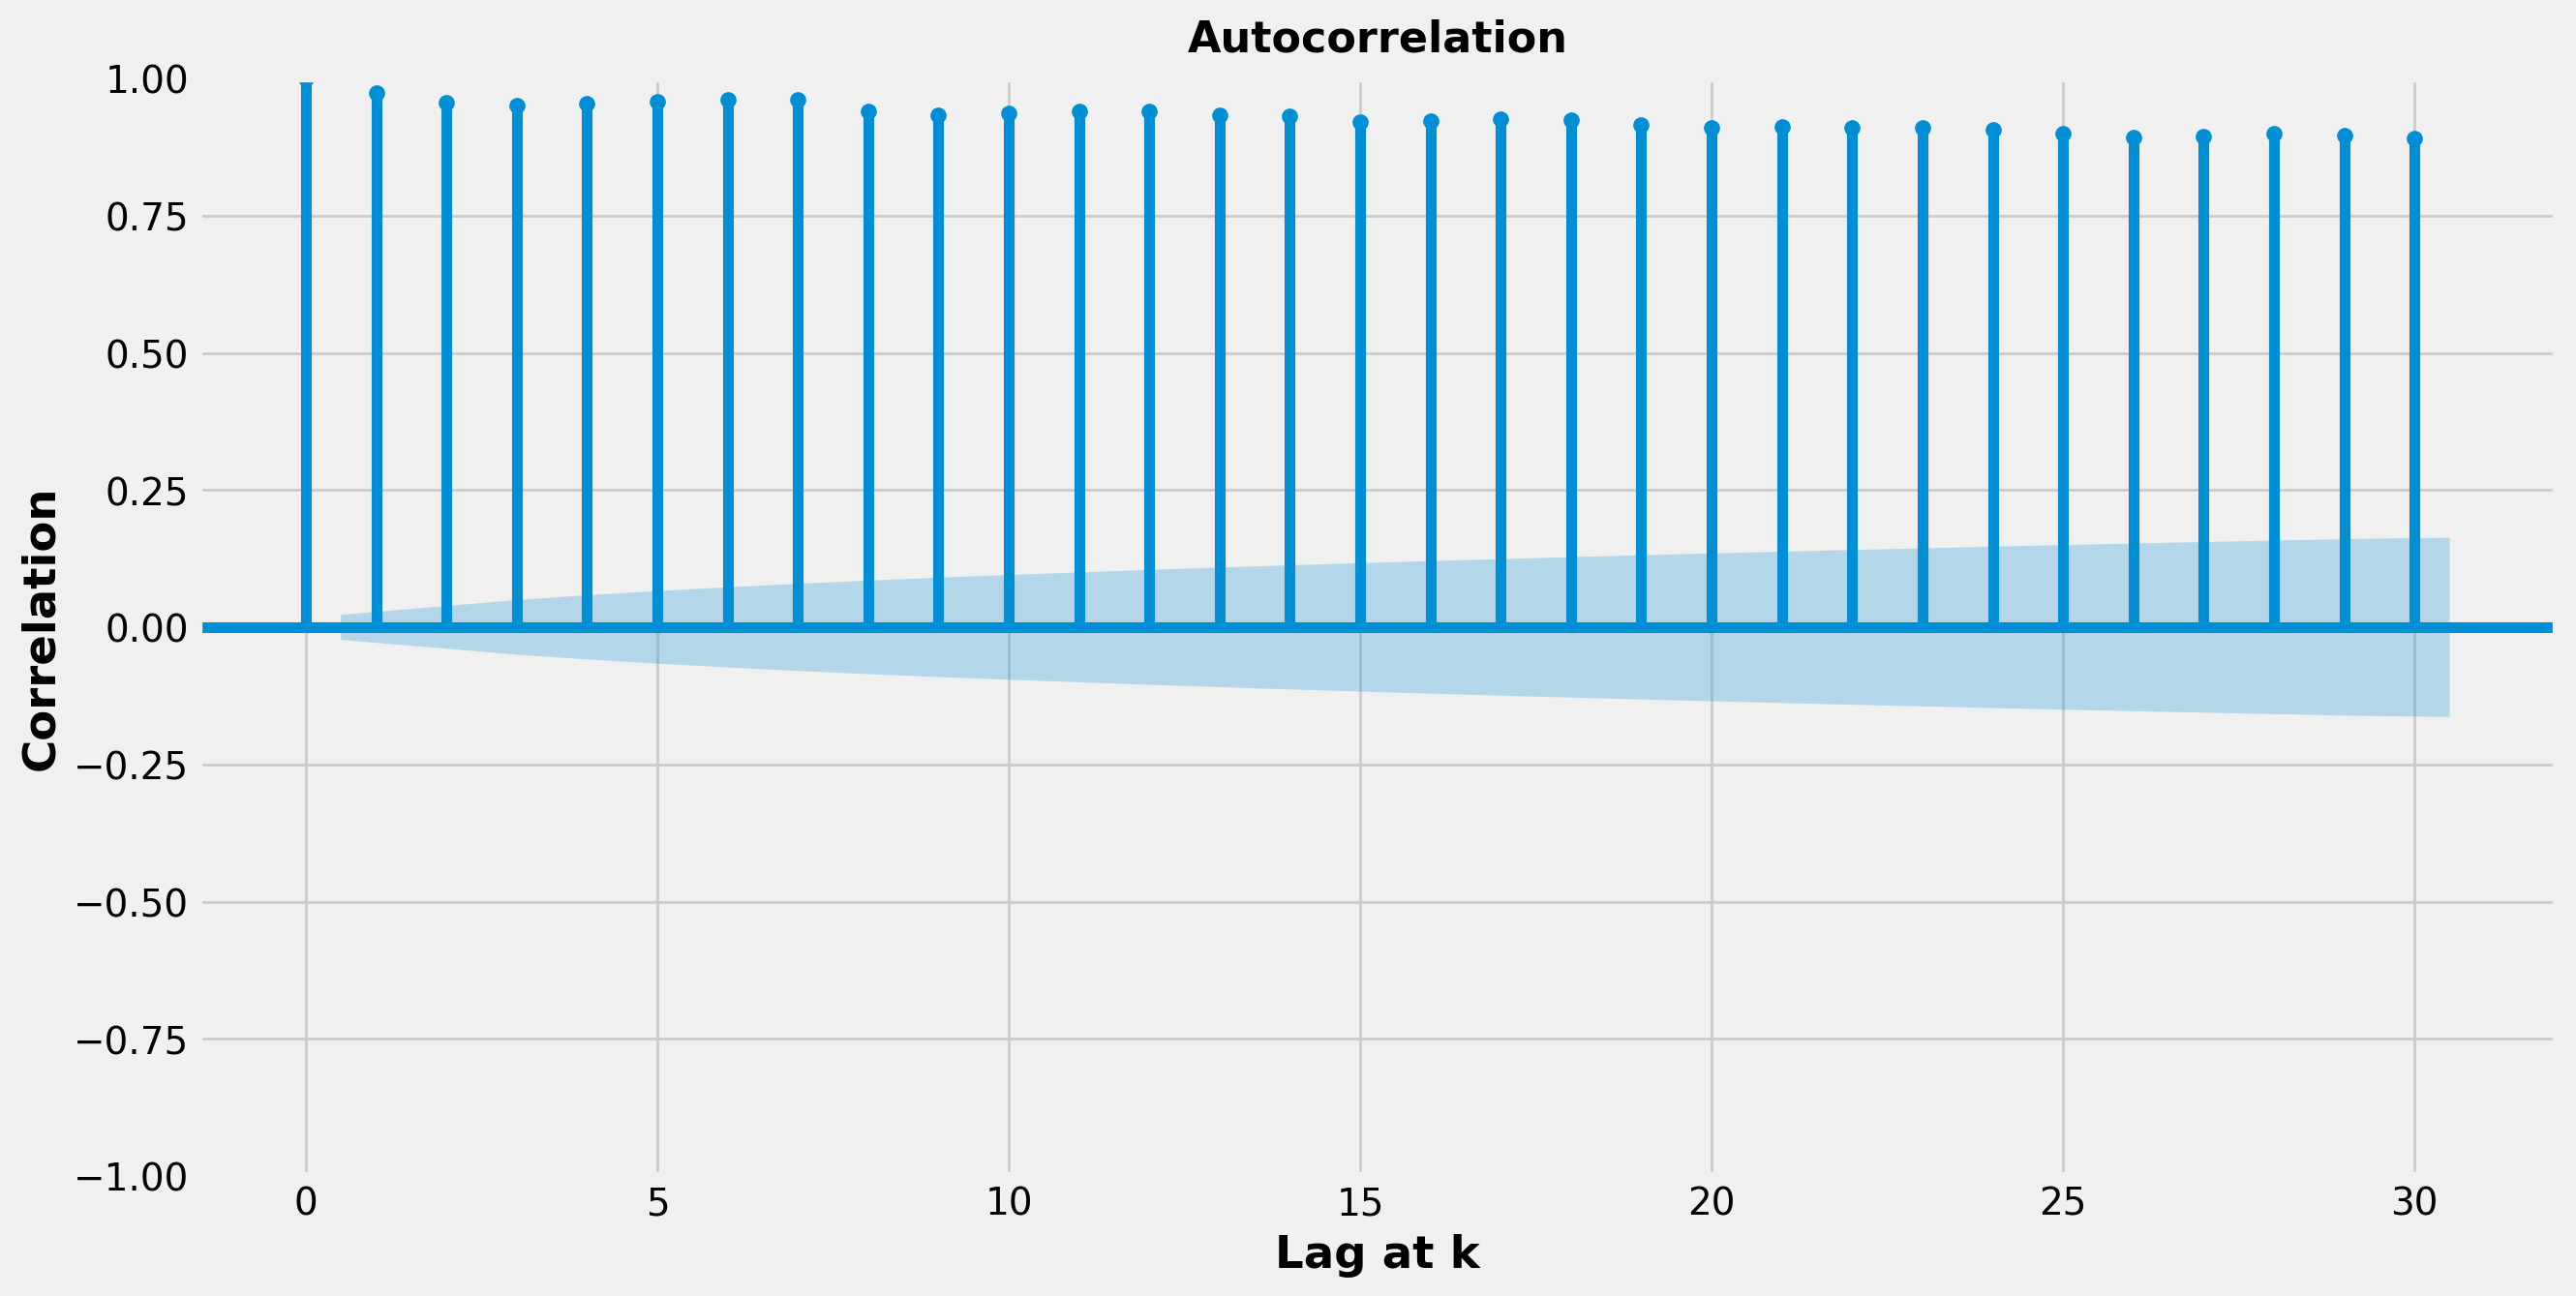

In [ ]:
from matplotlib import rcParams
from statsmodels.graphics.tsaplots import plot_acf

rcParams["figure.figsize"] = 14, 7
fig = plot_acf(train["orders"].ffill(), lags=30)
plt.title("Autocorrelation")
plt.ylabel("Correlation")
plt.xlabel("Lag at k")
plt.show()

In [ ]:
train['date'].min()

Timestamp('2020-12-05 00:00:00')

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_17721/1774785269.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='12/5/2012', end='1/1/2024', freq='M')


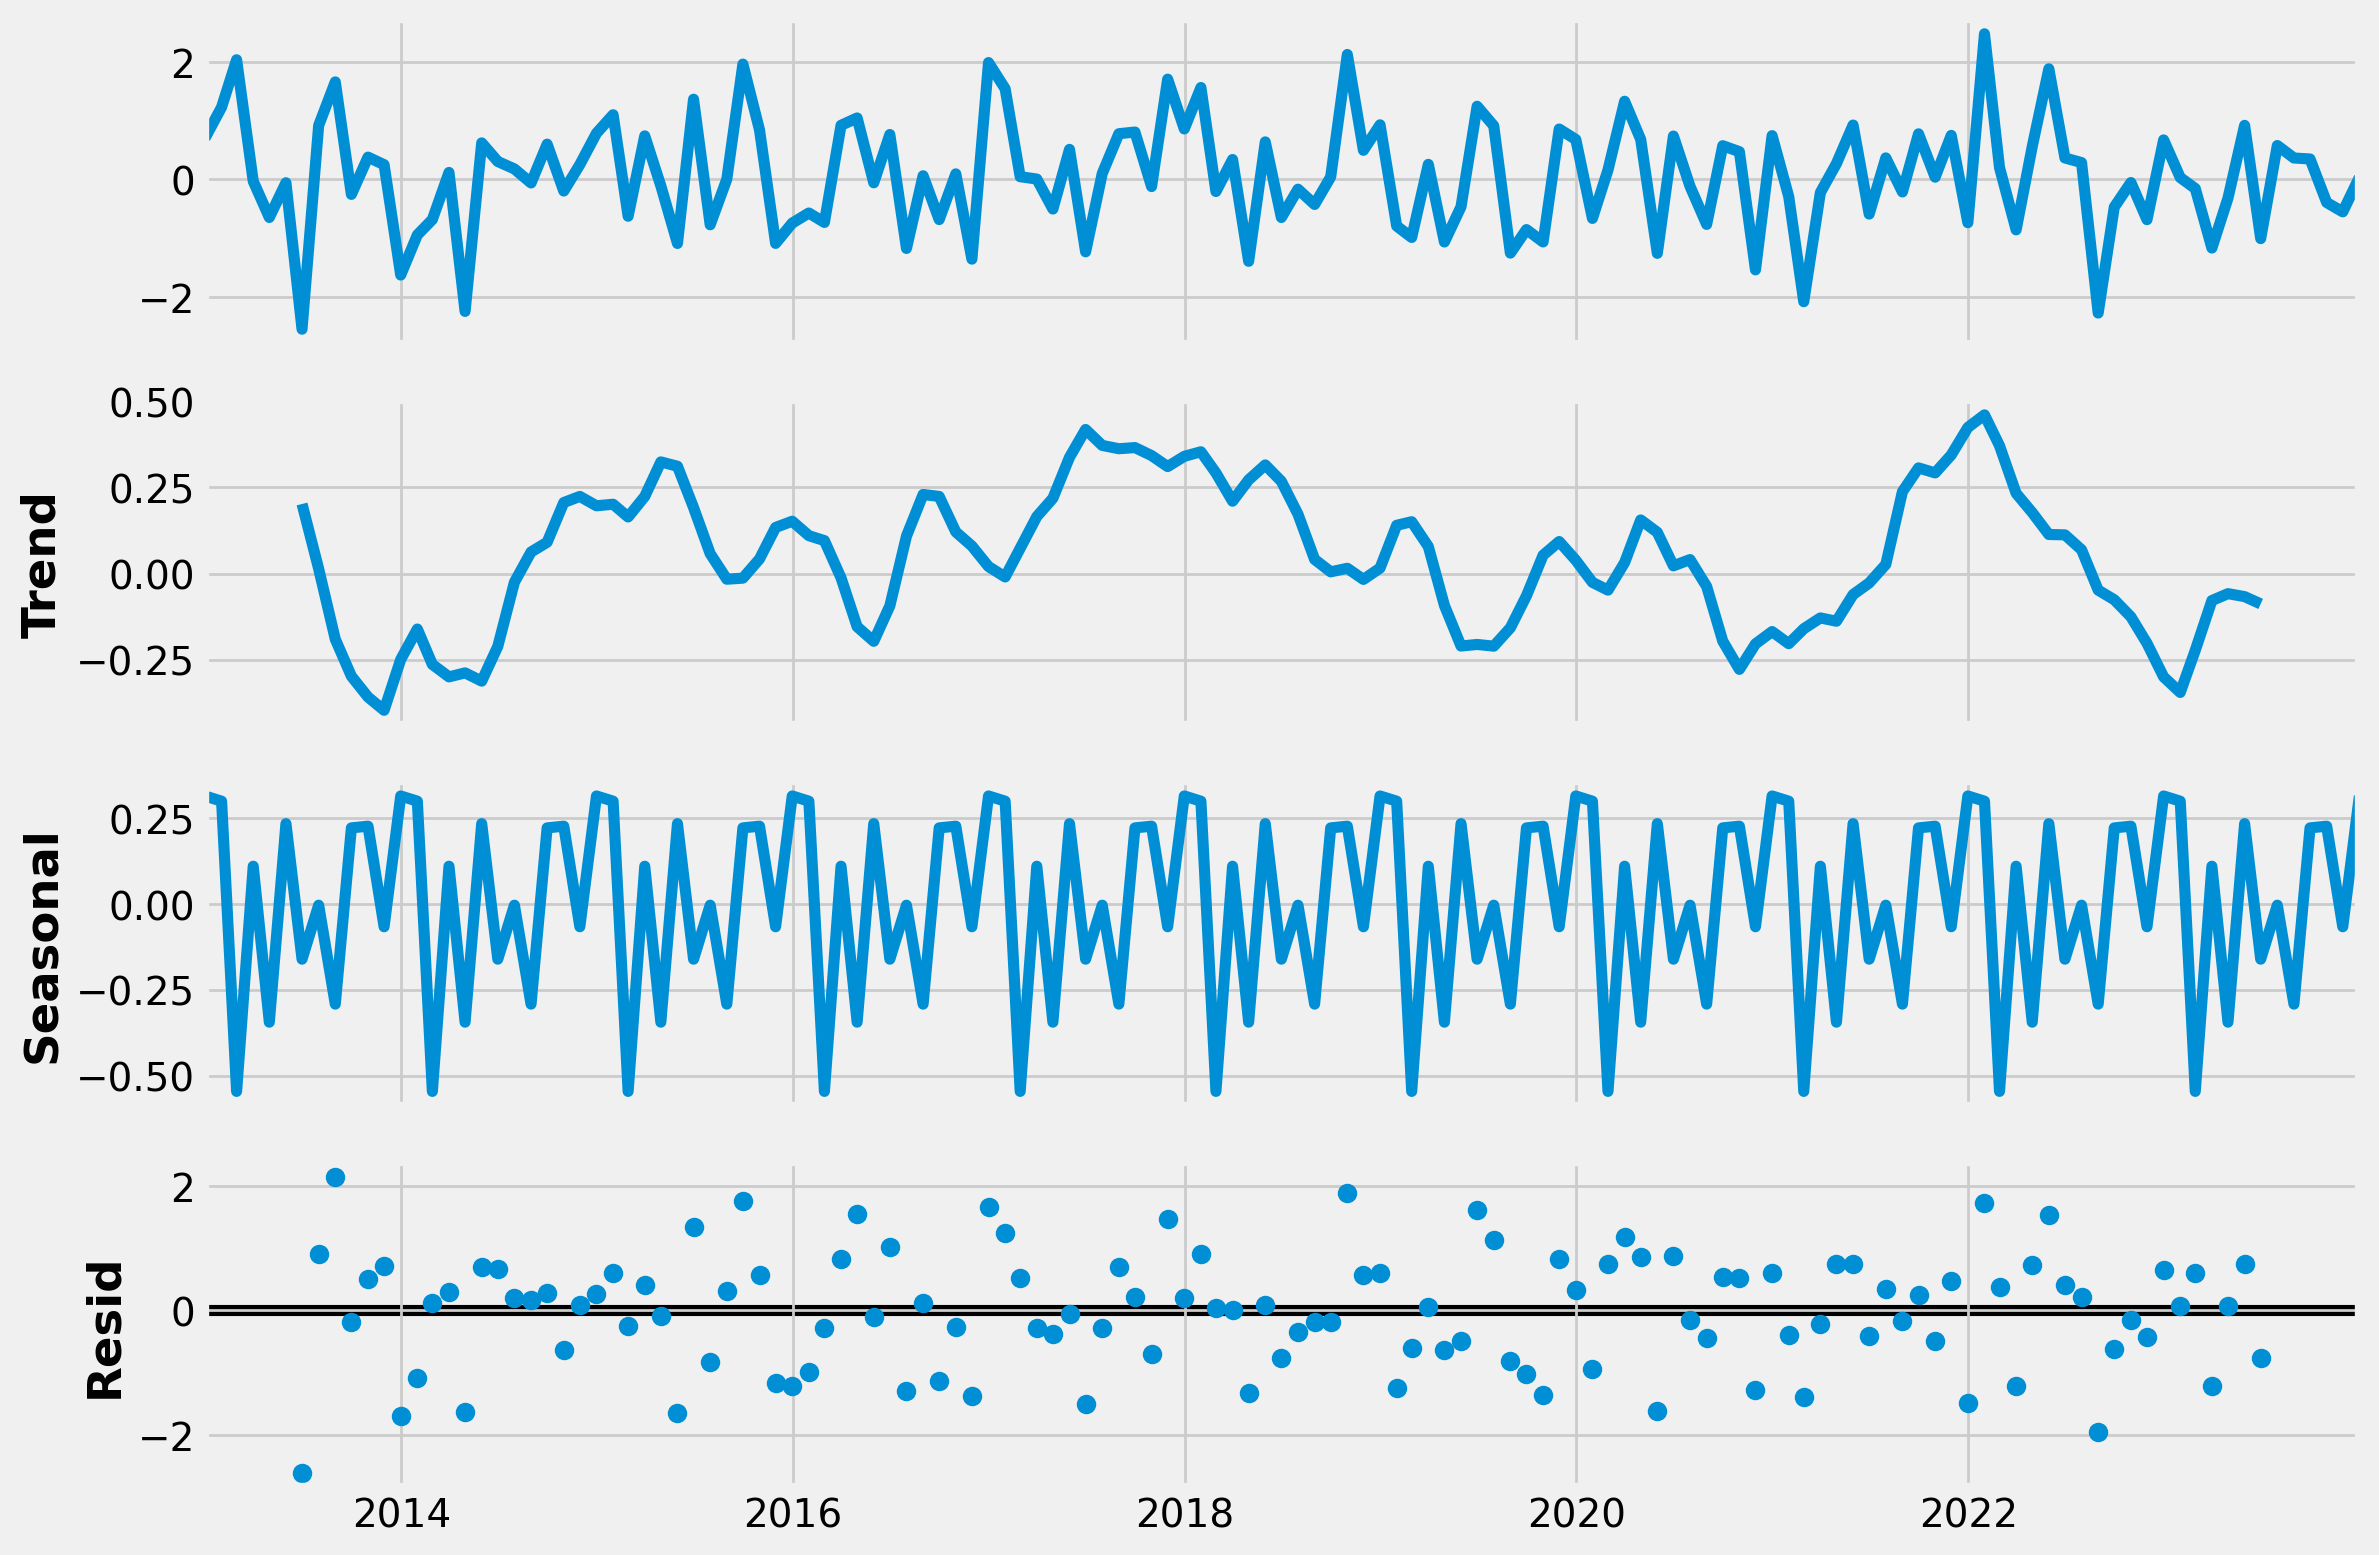

In [ ]:
date_rng = pd.date_range(start='12/5/2012', end='1/1/2024', freq='M')
bio = pd.Series(np.random.randn(len(date_rng)), index=date_rng)
bio = pd.Series(bio, index=date_rng)
CFG = {'img_dim1': 12, 'img_dim2': 8}
plt.rcParams.update({'figure.figsize': (CFG['img_dim1'], CFG['img_dim2'])})
decomposition = seasonal_decompose(bio, period=12)
figure = decomposition.plot()
plt.show()

# Encoding

In [ ]:
def encoding(train:  pd.DataFrame,test: pd.DataFrame) ->  pd.DataFrame: 
    encoder = LabelEncoder()
    cat_feats = train.select_dtypes(include='object')
    for df in(train,test):
        for col in df.columns:
            if col in cat_feats:
                df[col] = encoder.fit_transform(df[col])
    
    return df
encoding(train,test)
bio = train.dropna(axis=0)

# Building the CV

In [ ]:
def extract_date(train:pd.DataFrame,test: pd.DataFrame, feature='date') -> pd.Series:
    train_date = train['date']
    test_date = test['date']
    for df in (train,test):
        df.drop('date', axis=1, inplace=True)
    return train_date, test_date

train_date, test_date = extract_date(train=train,test=test,feature='date')


In [ ]:
for col in train.columns:
    if col not in test.columns:
        if col != 'orders':
            train.drop(columns=col,axis=1, inplace=True)

In [ ]:
model = LGBMRegressor(random_state = 777)
groups = train['warehouse']
n_splits = 5 
tscv = TimeSeriesSplit(n_splits=n_splits)

def validate(trainset, testset, target_col):
    model.fit(trainset.drop(columns=target_col), trainset[target_col])
    pred = model.predict(testset.drop(columns=target_col))
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = pred[valid_idx]
    print('std:', valid_testset.std())
    score = mean_absolute_percentage_error(valid_testset, valid_pred)
    print('score :',score)
    return score
stds = []
mapes = []

for train_index , test_index in tscv.split(train.drop(columns=['orders']), train['orders'], groups=groups): 
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    stds.append(test_v['orders'])
    mapes.append(validate(train_v,test_v,'orders'))
print('mape :' ,np.array(mapes).mean())
print('mapes stds :', np.array(mapes).std())
print('stds :', stds)
print('mapes :', mapes)

/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/venv-geoai-ground-level-no2-estimation/lib/python3.12/site-packages/sklearn/model_selection/_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 928
[LightGBM] [Info] Number of data points in the train set: 1225, number of used features: 15
[LightGBM] [Info] Start training from score 8476.468571
std: 1129.7141856748206
score : 0.18005240098321837
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in the train set: 2448, number of used features: 15
[LightGBM] [Info] Start training from score 7816.458333
std: 701.1422346142425
score : 0.10644241748582817
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing w

In [ ]:
model.fit(train.drop(columns='orders'),train['orders'])
y_predict = model.predict(test)
sub_df = pd.DataFrame({'id': test_ids,'orders':y_predict})
sub_df.to_csv('/Users/ahmed/Downloads/computerscience/AI-Compeitions/Rohlik Orders Forecasting Challenge/submiession/submissions04274142491537276.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 7340, number of used features: 16
[LightGBM] [Info] Start training from score 5535.443869


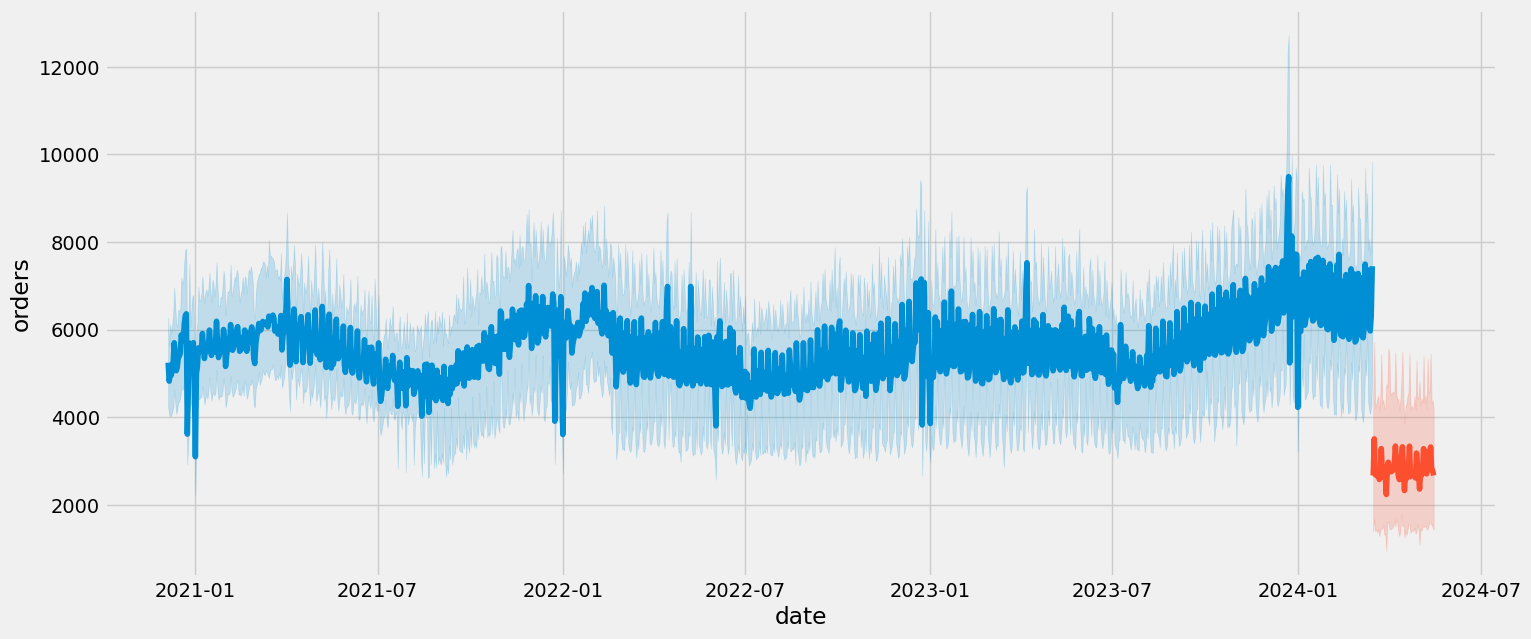

In [ ]:
plt.figure(figsize=(16 , 7))
sns.lineplot(x=train_date, y=train.orders)
sns.lineplot(x=test_date, y= y_predict)
plt.show()

In [ ]:
train.columns

Index(['warehouse', 'orders', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'id', 'date_day',
       'date_day_of_year', 'date_month', 'Year', 'month_sin', 'month_cos',
       'day_sin', 'day_cos', 'year_sin', 'year_cos'],
      dtype='object')

#check the dates of the test and the train 
#the publich leaderboard is not 30% first of the data and not the last 30% of the data. 
#read the book and finish the course 
#try the same methods here in the foreast one you build.